<a href="https://colab.research.google.com/github/Liping-LZ/BDAO_ECDA/blob/main/Clustering_session/customers_clustering_k_means_dbscan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='Top'></a>
<center>
    <h1><u><b>Mall Customers Segmentation</b></u></h1>
by Robert Kwiatkowski
</center>

---

This project shows how to perform a mall customers segmentation using Machine Learning algorithms. This is the unsupervised clustering problem and two popular algorithms will be presented and compared: KMeans and DBSCAN. There will be some further discussions about these algorithms alterations and their current state of developments/research. The main aim of this notebook is to cover the basics of clustering methods and touch some more advanced aspects as well.

The notebook is divided into six main sections. At the end of the notebook, you will find also references I used during the preparation of this notebook. In order to increase readability some code is hidded (so, please unhide them to see the code).

### SECTIONS:  
1. [Introduction](#Intro)<br>  
2. [Reading Data](#Reading_data)<br>  
3. [Clustering](#Clustering)<br>
   3.1 [K-Means](#K-Means)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.1.1 [Description](#K-Means_description)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.1.2 [Use case - customers segmentation](#K-Means_use_case)<br>
   3.2 [DBSCAN](#DBSCAN)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.2.1 [Description](#DBSCAN_description)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.2.2 [Use case - customers segmentation](#DBSCAN_use_case)<br>
4. [Comparison and discussion](#Comparison_and_discussion)<br>
5. [References](#References)<br>

<a id='Intro'></a>
## 1. Introduction  <a href='#Top' style="text-decoration: none;">^</a><br>


The main task of clustering is to discover „natural“ groups within an unlabelled dataset - this means that's an unsuprvised ML task. And it's an important one, as as it is used in many scientific, engineering and business domains. One of the most known application of clustering are:  
* customers segmentation (for efficient marketing)
* image segmentation
* documents clusterisation.
  
There are many clustering algorithms which can be divided into two main types: hierarchical and partitional.

* <u>Hierarchical</u> algorithms recursively split a dataset into a smaller subset until a subset contains only one item. This can be represented with a dendrogram which looks like a tree. It can be constructed from leaves to the roo(agglomerative approach) or from the root down to the leaves (divisive approach). In hierarchical clustering, you don’t have to specify the number of clusters but you have to define a termination condition for splitting/merging process. </li>     

* <u>Partitional</u> algorithms divide a dataset into several subsets (clusters) based on a given criteria. For some algorithms number of clusters has to be defined a priori (e.g K-Means) and for some not (DBSCAN). Defining the number of clusters before running an algorithm often requires a specific domain knowledge which is often challenging (or even impossible) in many applications. This led to the development of many heuristics and simplified approaches helping analyst without domain knowledge to choose the appropriate number of clusters.</li>

There is a vast number of clustering algorithms and currently, there is no single one that dominates other ones. Choosing the best one depends on the database itself, an application domain and client requirements and expectations.
This notebook focuses on two partitional algorithms: K-Means and DBSCAN. All are implemented in a well-known Python library: Scikit-Learn.

<a id='Reading_data'></a>
## 2. Reading data <a href='#Top' style="text-decoration: none;">^</a><br>

In this section, raw data will be read, overviewed and checked if any cleaning is required.

In [1]:
# First, we need to load the dataset into Google Colab.
# This statement allows you to select the file from your laptop and upload it to Google Cloud.
# Please wait until you see 100% done and the play button is resumed. it might take a while to upload because the dataset is large

# Import necessary Python libraries
from google.colab import files

#Upload the dataset to Google Colab
uploaded = files.upload()

Saving Mall_Customers.csv to Mall_Customers.csv


In [ ]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [ ]:
# Load the dataset
mall_data = pd.read_csv('Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


There are 5 columns:
* `Customer ID` - numerical - unique customer number - integer
* `Gender` - categorical - binary (Male/Female)
* `Age` - numerical - integer
* `Annual Income (k$)` - numerical - integer
* `Spending Score (1-100)` - numerical - integer

There is one binary, categorical column: ```gender```. You may be tempted to one-hot encode it for the clustering. It is:
* technically possible
* theoretically not forbidden
* practically not recommended

However, it is not recommended and nicely explained on the [IBM support site](https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided).

In [ ]:
# Check for missing values and remove them (if any)

mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

There are no missing data. This simplifies the analysis but it is a very unlikely scenario in a real-life where analysts spend a significant amount of time cleaning their data before the core analysis is performed

<a id='Clustering'></a>
## 3. Clustering<a href='#Top' style="text-decoration: none;">^</a><br>  

This section of the notebook describes and demonstrates how to use two clustering algorithms:  
* K-Means
* Density-Based Spatial Clustering of Applications with Noise (DBSCAN)


I will not standarize data for this case. When you should or should do it is nicely explained [here on Data Science Stack Exchange](https://datascience.stackexchange.com/questions/6715/is-it-necessary-to-standardize-your-data-before-clustering).

<a id='K-Means'></a>
### 3.1 K-Means<a href='#Top' style="text-decoration: none;">^</a><br>  

This chapter focuses on a very popular K-Means algorithm being taught in most machine learning courses. The chapter contains two sub-chapters: description of the algorithm and a use case (mall customers segmentation).

<a id='K-Means_description'></a>
### 3.1.1 Description<a href='#Top' style="text-decoration: none;">^</a><br>  

The most well-known partitional clustering algorithm is K-Means. It was independently developed in many places in the 50s and 60s and gained great popularity because of its ease of implementation, simplicity and many empirical successes (e.g. in business, medicine and science).  

There are 3 main steps in K-Means algorithm (known also as Lloyd’s algorithm):
<ol>
    <li>Split samples into initial groups by using seed points. The nearest samples to these seed point will create initial clusters.</li>
    <li>Calculate samples distances to groups’ central points (centroids) and assign the nearest samples to their cluster.</li>
    <li>The third step is to calculate newly created (updated) cluster centroids.</li>
</ol>
Then repeat steps 2 and 3 until the algorithm converges.<br>  

As mentioned earlier the goal of K-Means is to minimise the objective function (inertia) over all clusters. The objective function is to minimise thewithin-cluster distance (the distance between the cluster centroid and the data points in the cluster).

This is known as NP-hard problem, meaning this is a greedy algorithm and converges to the local minimum. The computational cost of Lloyd’s K-Means algorithm is O(kn), where k is a number of clusters and n is a number of samples. This is not bad when compared with other clustering algorithms. Despite converging usually to a local minimum, K-means is relatively fast and when groups are well isolated from each other it is likely that it converges to the global minimum. Because the result of clusterisation depends on the initialisation criteria it is common to run the analysis for various initialisation points and choose the one with minimum resultant inertia. There are some improvements to the algorithm solving problem of the local minima. One, exemplary, improvement is to use enhanced Firefly Algorithms about which you can read [here](https://www.sciencedirect.com/science/article/pii/S1568494619305447).<br><br>

In general, a user of the K-Means algorithm is required to define three main parameters:<br>  

1. **Initialisation criteria**  
    In scikit-learn, a clever initialisation scheme is implemented: “k-means++” proposed by Arthur and Vassilvitskii. It creates initial centroids generally distant from each other increasing probability of obtaining better results. There is also a possibility to use a random point’s generator. There are ongoing efforts to create the most efficient seeding method for K-Means algorithm, one of them is based on Independent Component Analysis and you can read more about it [here](http://www.ymd.nii.ac.jp/lab/publication/conference/2010/IWI-Onoda-2010.pdf).

2. **Number of clusters**  
    Selecting a number of clusters is the most challenging part of setting this algorithm. There are no hard mathematical criteria for this and many heuristic/simplified approaches have been developed. One of the simplest and the most popular one is the elbow method shown in this analysis. Additionaly a silhouette score will be used as well.
    There are also other, often advanced, options for choosing the optimal number of clusters (however, not used in this notebook and not implemented in sklearn), e.g.:
    

* Minimum Message Length (MML) - [more](https://en.wikipedia.org/wiki/Minimum_message_length)
* Minimum Description Length (MDL) - [more](https://en.wikipedia.org/wiki/Minimum_description_length)
* Bayes Information Criterion (BIC) - [more](https://en.wikipedia.org/wiki/Bayesian_information_criterion)
* Akaike Information Criterion (AIC) - [more](https://en.wikipedia.org/wiki/Akaike_information_criterion)
* Dirichlet Process
* Gap statistics


3. **A distance metric (not required in scikit learn implementation)**  
    There are various options to calculate the distance between points. The most popular one is simply the Euclidean metric and it is the one implemented in scikit-learn. It is often called spherical k-means model. It has a drawback that it finds spherical-like groups only and tends to become inflated in highly multi-dimensional analyses (“curse of dimensionality”). There are other options but not implemented in scikit-learn, e.g.:
    
    
* Mahalonobis distance (high computiational cost)
* Itakura-Saito distance
* L1 distance
* Cosine distance
* Bregman distance


There are numerous ongoing researches and variations proposed to K-Means, e.g.:  
* K-Medoid where the centroid is defined as the most centrally located object)
* K-Median where the centroid is calculated using median instead of a mean,
* Fuzzy C-means model

Some take-aways about K-Means:

1. Euclidean distances are used
2. Number of clusters has to be defined for the algorithm
3. Centroid is calculated using mean distance to cluster members
4. Clusters are assumed isotropic and convex
5. Stochastic algorithm – results depend on the initialisation criteria
6. Creates groups of equal variance (minimises inertia)
7. Prone to the “curse of dimensionality”
8. Can be run in parallel – so it scales well

<a id='K-Means_use_case'></a>
### 3.1.2 Use case - customers segmentation<a href='#Top' style="text-decoration: none;">^</a><br>  

The very first step in a clustering analysis is importing K-Means from the sklearn library.

In [ ]:
from sklearn.cluster import KMeans

For clustering only numeric columns are used. As mentioned at the beginning the binary variable `gender` will not be used here.

In [ ]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

In order to find an appropriate number of clusters, the elbow method will be used. In this method for this case, the inertia for a number of clusters between 2 and 10 will be calculated. The rule is to choose the number of clusters where you see a kink or "an elbow" in the graph.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

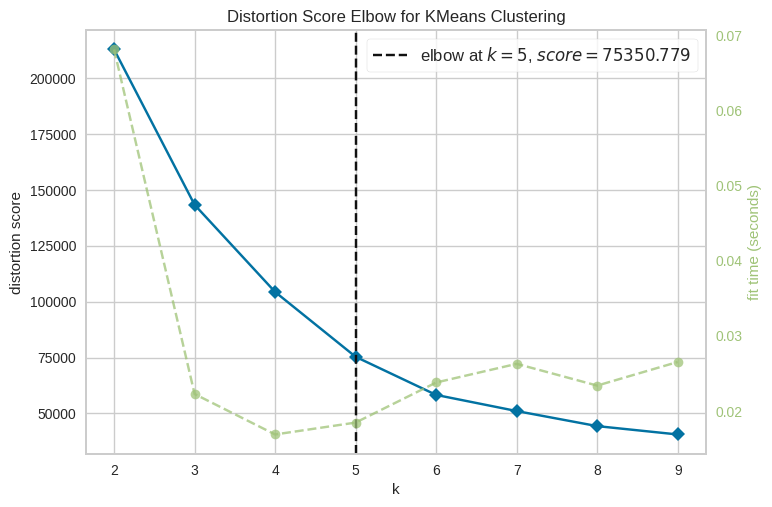

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

The graph above shows the reduction of a distortion score as the number of clusters increases. However, there is no clear "elbow" visible. The underlying algorithm suggests 5 clusters. A choice of 5 or 6 clusters seems to be fair.

Another way to choose the best number of clusters is to plot the silhuette score in a function of number of clusters. Let's see the results.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

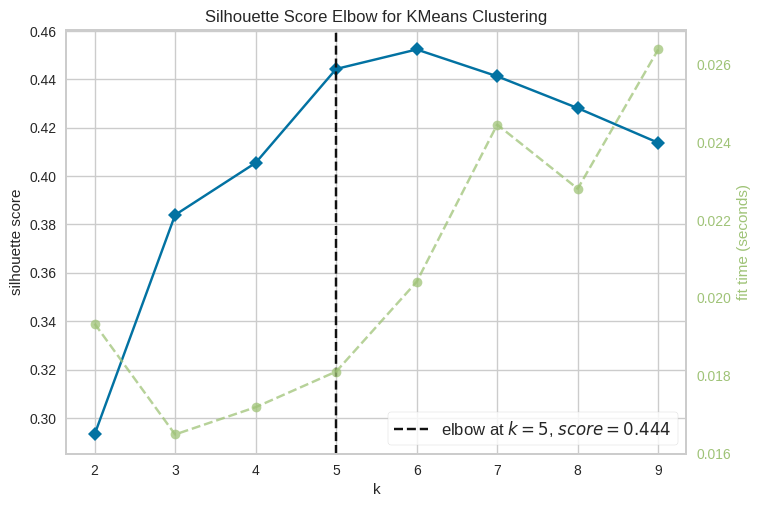

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

Silhouette score method indicates the best options would be 5 or 6 clusters. Let's compare both.

<u>**5 CLUSTERS**</u>

In [ ]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


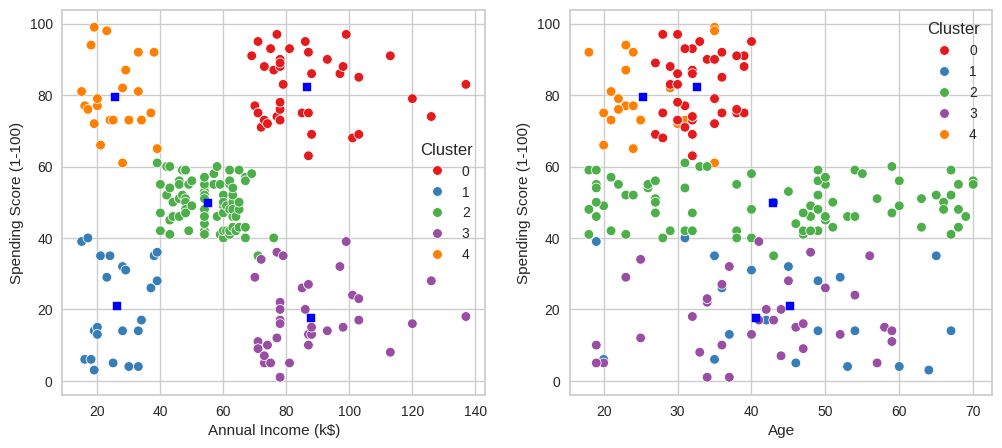

In [ ]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means algorithm generated the following 5 clusters:
* clients with **low** annual income and **high** spending score
* clients with **medium** annual income and **medium** spending score
* clients with **high** annual income and **low** spending score
* clients with **high** annual income and **high** spending score
* clients with **low** annual income and **low** spending score

There are no distinct groups is terms of customers age.

Sizes of the clusters:

Cluster Statistics:
   Cluster  CustomerCount  AverageAge  AverageAnnualIncome  \
0        0             39   32.692308            86.538462   
1        1             23   45.217391            26.304348   
2        2             80   42.937500            55.087500   
3        3             36   40.666667            87.750000   
4        4             22   25.272727            25.727273   

   AverageSpendingScore  
0             82.128205  
1             20.913043  
2             49.712500  
3             17.583333  
4             79.363636  


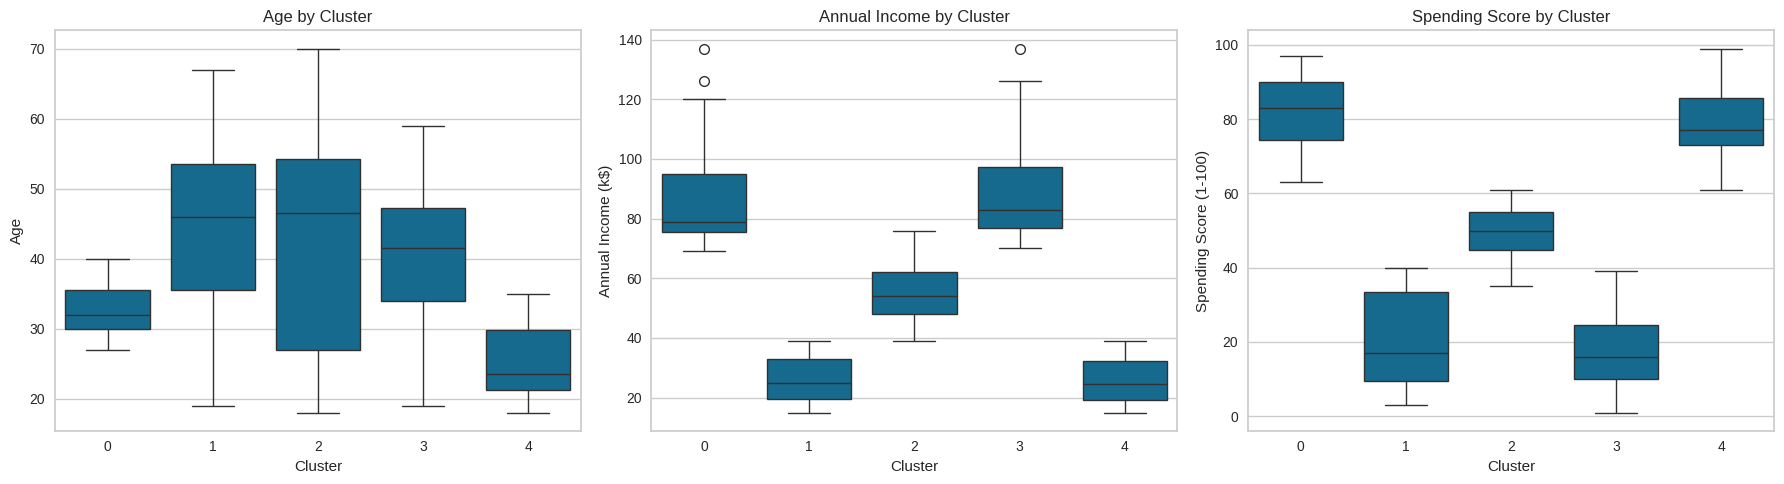

In [ ]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

# 8. Print and create Boxplots for cluster statistics
# Calculate statistics for each cluster
print("Cluster Statistics:")
cluster_stats = KM5_clustered.groupby('Cluster').agg({
    'Age': ['count', 'mean'],
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean'
}).reset_index()

cluster_stats.columns = ['Cluster', 'CustomerCount', 'AverageAge', 'AverageAnnualIncome', 'AverageSpendingScore']
print(cluster_stats)

# 9. Display Boxplots for the statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='Cluster', y='Age', data=KM5_clustered, ax=axes[0])
axes[0].set_title('Age by Cluster')
sns.boxplot(x='Cluster', y='Annual Income (k$)', data=KM5_clustered, ax=axes[1])
axes[1].set_title('Annual Income by Cluster')
sns.boxplot(x='Cluster', y='Spending Score (1-100)', data=KM5_clustered, ax=axes[2])
axes[2].set_title('Spending Score by Cluster')
plt.tight_layout()
plt.show()

The biggest cluster is a cluster number 1 with 79 observations ("medium-medium" clients). There are two the smallest ones each containing 23 observations (cluster 3 "high-high" and cluster 0 "low-high" clients).

To check the quality of each cluster we can examine the Silhuette plot.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



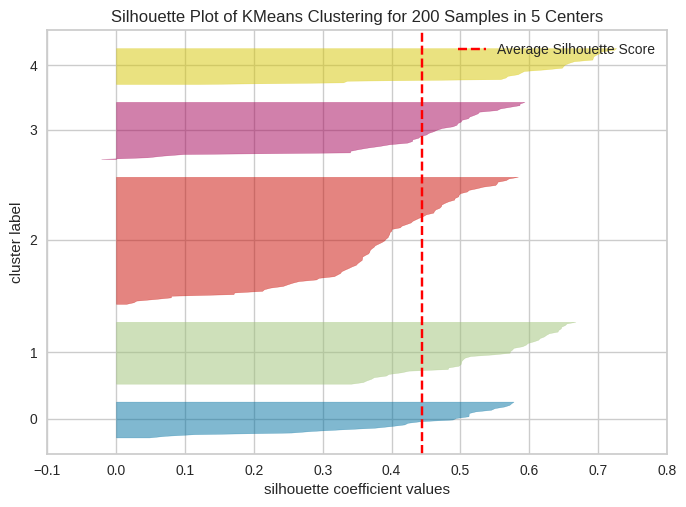

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

<a id='DBSCAN'></a>
### 3.2 DBSCAN<a href='#Top' style="text-decoration: none;">^</a><br>  

This chapter describes how DBSCAN (Density-Based Spatial Clustering of Applications with Noise) works and shows its implementation to the mall customers segmentation.

<a id='DBSCAN description'></a>
### 3.2.1 Description<a href='#Top' style="text-decoration: none;">^</a><br>  
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise and is one of clustering algorithms implemented in scikit-learn library. It was proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996 in their famous article <a href="https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf?source=post_page---------------------------">“A Density-Based Algorithm for Discovering Clusters in Large Spatial Database with Noise”</a>.  

As the name of paper suggests the core idea of DBSCAN is around concept of dense regions. The assumption is that natural clusters are composed of densely located points. This requires definition of “dense region”. To do these two parameters are required for DBSCAN algorithm.  
* Eps, ε  - distance
* MinPts – Minimum number of points within distance Eps  

Optionally the distance metric can be specified by a user, but usually Euclidean distance is implemented (like in scikit learn).  

A “dense region” is therefore created by a minimum number of points within distance between all of them, Eps. Points which are within this distance but not close to minimum number of other points are treated as “border points”. Remaining ones are noise or outliers. This is shown in the picture below (for MinPts=3). Red points (D) are in a “dense region” – each one has minimum of 3 neighbours within distance Eps. Green points (B) are border ones – they have a neighbour within distance Eps but less than 3. Blue point (O) is an outlier – no neighbours within distance Eps.

![DBSCAN.jpg](attachment:DBSCAN.jpg)

Advantages of this approach:
* it finds number of clusters itself, based on eps and MinPts parameters
* It it able to differentiate elongated clusters or clusters surrounded by other clusters in contrary to e.g. K-Means where clusters are always convex.
* It is also able to find points not fitting into any cluster – it detects outliers.  

The biggest drawback of DBSCAN:
* High computational expense of average O(n log(n)) coming from a need to execute a neighbourhood query for each point.
* Poorly identifies clusters with various densities

There are various variations and extensions proposed by machine learning researchers to DBSCAN algorithm. For example:
* W. Jing Ch. Zhao and Ch. Jing proposed <a href="https://www.sciencedirect.com/science/article/pii/S1877050919302273">“An improvement method of DBSCAN algorithm on cloud computing”.</a> to solve problem of scalability.
* H. You, L. Chen, J. Yao and X. Wang proposed <a href="https://www.sciencedirect.com/science/article/pii/S0020025516300561">“A three-way clustering method based on an improved DBSCAN algorithm”</a> to overcome problem of clusters with various densities.


<a id='DBSCAN use case'></a>
### 3.2.2 Use case - customers segmentation<a href='#Top' style="text-decoration: none;">^</a><br>  

The first step - importing DBSCAN from sklearn.

In [ ]:
from sklearn.cluster import DBSCAN

In DBSCAN there are two major hyperparameters:
* `eps`
* `min_samples`

It is difficult arbitrarily to say what values will work the best. Therefore, I will first create a matrix of investigated combinations.

In [ ]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

Because DBSCAN creates clusters itself based on those two parameters let's check the number of generated clusters.

In [ ]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

A heatplot below shows how many clusters were generated by the DBSCAN algorithm for the respective parameters combinations.

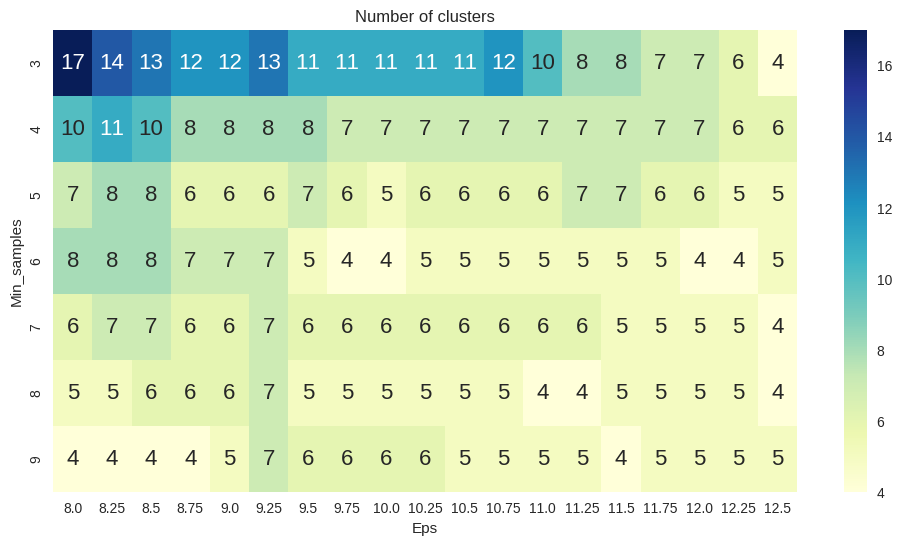

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

The heatplot above shows, the number of clusters vary from 17 to 4. However, most of the combinations gives 4-7 clusters.
To decide which combination to choose I will use a metric - a silhuette score and I will plot it as a heatmap again.

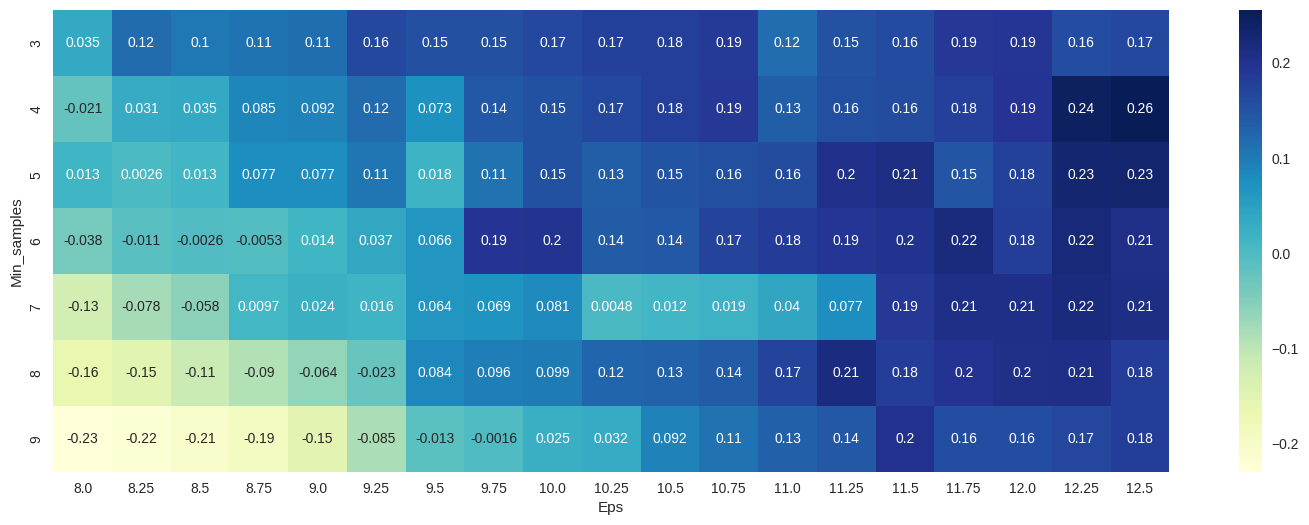

In [ ]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Global maximum is 0.26 for `eps`=12.5 and `min_samples`=4.

In [ ]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

Checking sizes of clusters.

         DBSCAN_size
Cluster             
-1                18
 0               112
 1                 8
 2                34
 3                24
 4                 4
Cluster Statistics:
   Cluster  CustomerCount  AverageAge  AverageAnnualIncome  \
0       -1             18   36.944444               74.000   
1        0            112   39.142857               48.250   
2        1              8   53.250000               27.750   
3        2             34   32.882353               82.000   
4        3             24   45.583333               85.875   
5        4              4   20.750000               76.250   

   AverageSpendingScore  
0             44.944444  
1             52.339286  
2              9.500000  
3             83.235294  
4             17.958333  
5              8.000000  


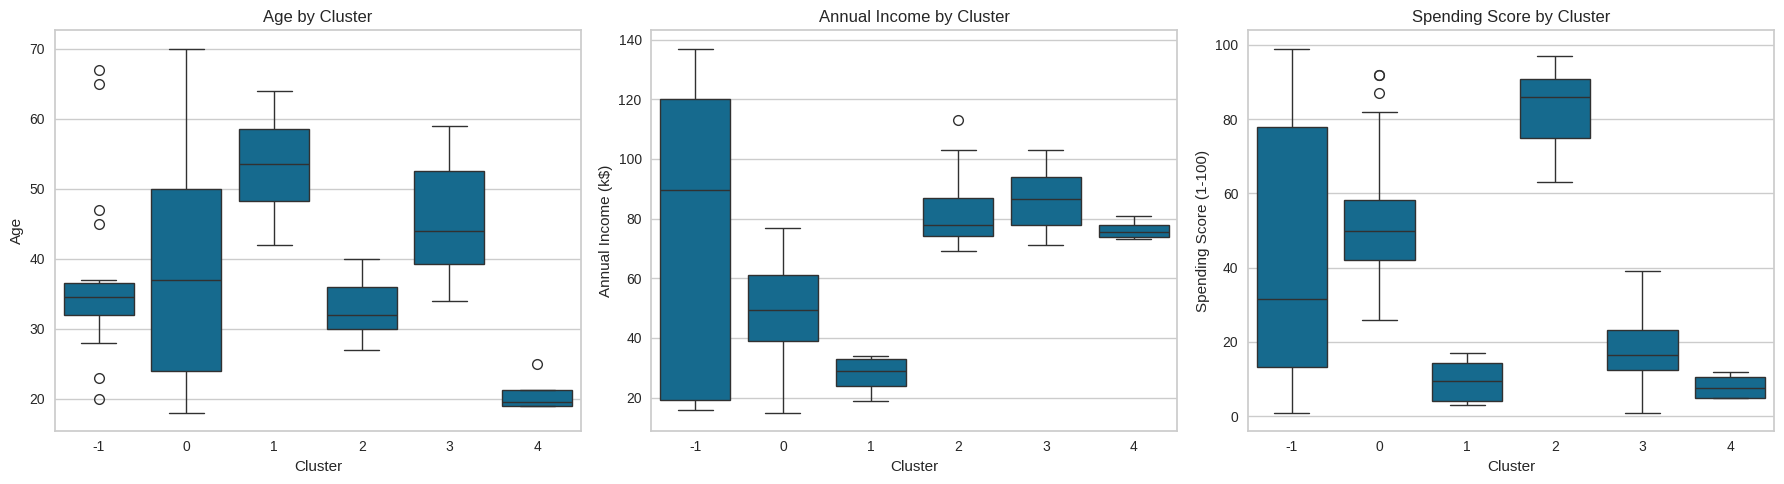

In [ ]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
print(DBSCAN_clust_sizes)

# 8. Print and create Boxplots for cluster statistics
# Calculate statistics for each cluster
print("Cluster Statistics:")
cluster_stats = DBSCAN_clustered.groupby('Cluster').agg({
    'Age': ['count', 'mean'],
    'Annual Income (k$)': 'mean',
    'Spending Score (1-100)': 'mean'
}).reset_index()

cluster_stats.columns = ['Cluster', 'CustomerCount', 'AverageAge', 'AverageAnnualIncome', 'AverageSpendingScore']
print(cluster_stats)

# 9. Display Boxplots for the statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='Cluster', y='Age', data=DBSCAN_clustered, ax=axes[0])
axes[0].set_title('Age by Cluster')
sns.boxplot(x='Cluster', y='Annual Income (k$)', data=DBSCAN_clustered, ax=axes[1])
axes[1].set_title('Annual Income by Cluster')
sns.boxplot(x='Cluster', y='Spending Score (1-100)', data=DBSCAN_clustered, ax=axes[2])
axes[2].set_title('Spending Score by Cluster')
plt.tight_layout()
plt.show()

DBSCAN created 5 clusters plus outliers cluster (-1). Sizes of clusters 0-4 vary significantly - some have only 4 or 8 observations. There are 18 outliers.

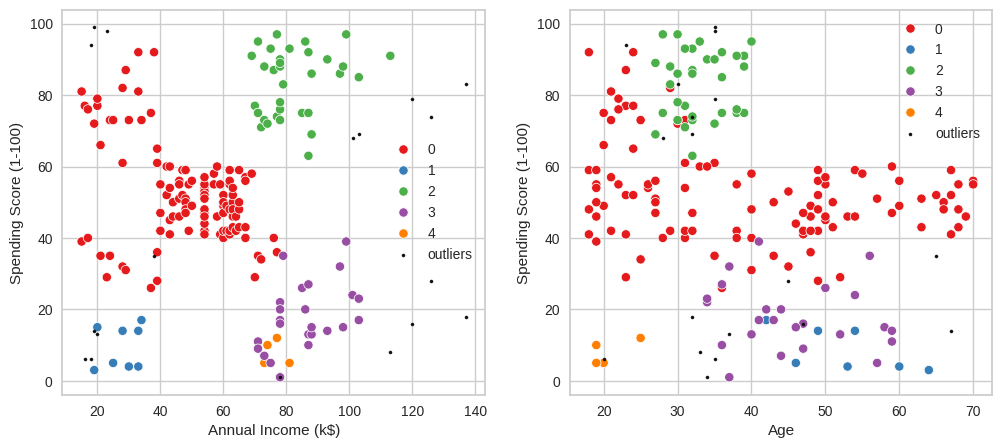

In [ ]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

The graph above shows that there are some outliers - these points do not meet distance and minimum samples requirements to be recognised as a cluster.

Clusters generated by the Affinity Propagation algorithm created relatively even-sized clusters similar to ones created by K-Means.

<a id='Comparison and discussion'></a>
## 5. Comparison and discussion <a href='#Top' style="text-decoration: none;">^</a><br>

In this chapter clusters genereated by 2 investigated algorithms will be compared and discussed.

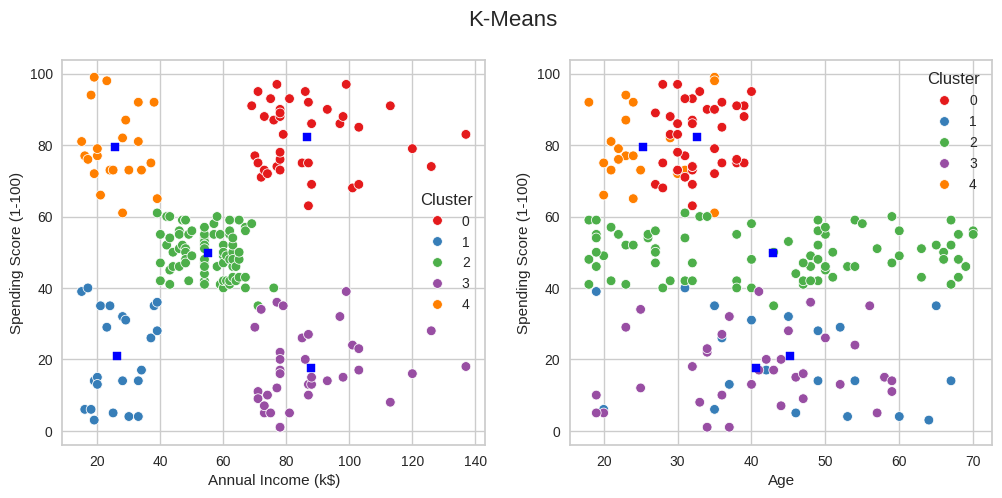

In [ ]:
fig1.suptitle('K-Means', fontsize=16)
fig1

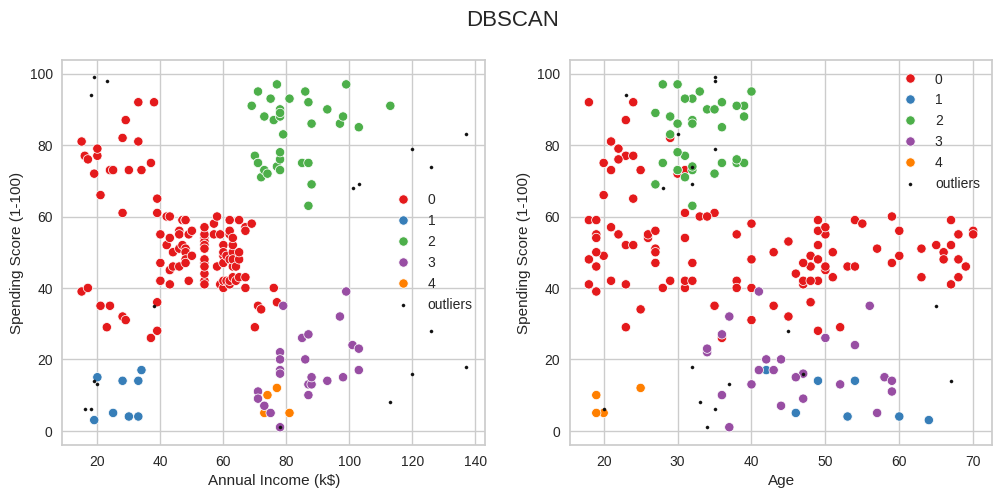

In [ ]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

From the above comparisons, it is clear that DBSCAN failed to generate reasonable clusters. It is most likely because DBCSAN tries to find clusters based on the density of points. If one of our clusters is less dense than others DBSCAN will produce suboptimal results by not recognising the least dense group as a cluster.

In turn, K-Means and Affinity Propagation algorithms created reasonable 6 clusters.

<a id='References'></a>
## References <a href='#Top' style="text-decoration: none;">^</a><br>


[1] 	H. Yu, L. Chen and X. Wang, "A three-way clustering method based on an improved DBSCAN algorithm," Physica A: Statistical Mechanics and its Applications, vol. 535, 2019.<br>
[2] 	W. Jing, C. Zhao and C. Jiang, "An improvement method of DBSCAN algorithm on cloud computing," Procedia Computer Science, vol. 147, pp. 596-604, 2019. <br>
[3] 	M. Ester, H.-P. Kriegel, J. Sander and X. Xu, "A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise," KDD-96 Proceedings, pp. 226-231, 1996. <br>
[4] 	D. Arthur and S. Vassilvitskii, "k-means++: The Advantages of Careful Seeding," Proceedings of the eighteenth annual ACM-SIAM symposium on Discrete algorithms, 2007. <br>
[5] 	B. Frey and D. Dueck, "Clustering by Passing Messages Between Data Points," Science, vol. 315, no. 5814, pp. 972-976, 2007. <br>
[6] 	P. Li, H. Ji, B. Wang, Z. Huang and H. Li, "Adjustable preference affinity propagation clustering," Pattern Recognition Letters, vol. 85, pp. 72-78, 2017. <br>
[7] 	H. Wenlong , F.-l. Chung and S. Wang, "Transfer affinity propagation-based clustering," Information Sciences, vol. 348, pp. 337-356, 2016.

# Your Turn!

In [2]:
# First, we need to load the dataset into Google Colab.
# This statement allows you to select the file from your laptop and upload it to Google Cloud.
# Please wait until you see 100% done and the play button is resumed. it might take a while to upload because the dataset is large

# Import necessary Python libraries
from google.colab import files

#Upload the dataset to Google Colab
uploaded = files.upload()

Saving supermarket_data_cleaned.csv to supermarket_data_cleaned.csv


In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Load the dataset
df2 = pd.read_csv('supermarket_data_cleaned.csv')

# First, check and print the number of missing values (if there are any) in the dataset
print("Number of missing values:")
print(df2.isnull().sum())

# Drop rows where customer ID is empty/missing as it's essential for our analysis
df2.dropna(inplace=True)

# 2. Removing duplicates
# Drop duplicate rows to ensure data quality
df2.drop_duplicates(inplace=True)

print("First five rows of the dataset:")
print(df2.head())

print("Size of the dataset:")
print(df2.shape)

X_numerics = df2[['Age', 'Num_children', 'Family_size', 'Income', 'Recency',
                        'Total_spent', 'Total_num_purchase', 'Register_days', 'MntWines',
                        'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                        'MntSweetProducts', 'MntGoldProds']] # subset with numeric variables only4


model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

KM_5_clusters = KMeans(n_clusters=4, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

KM_5_clusters = KMeans(n_clusters=4, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

# Calculate the average of values for every cluster
cluster_averages = KM5_clustered.groupby('Cluster').mean()
print("Average values for each cluster:")
print(cluster_averages)

# Plotting boxplots for each feature in each cluster
# This will be done in a loop over each numerical feature
features = ['Age', 'Num_children', 'Family_size', 'Income', 'Recency',
            'Total_spent', 'Total_num_purchase', 'Register_days', 'MntWines',
            'MntFruits', 'MntMeatProducts', 'MntFishProducts',
            'MntSweetProducts', 'MntGoldProds']

for feature in features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Cluster', y=feature, data=KM5_clustered)
    plt.title(f'Boxplot of {feature} by Cluster')
    plt.show()